# Biol 359A | Regularization
### Spring 2025, Week 4
Objectives:
- Understand the Bias-Variance Tradeoff: Learn how increasing model complexity impacts bias and variance.
- Gain intuition for Regularization Techniques: Implement Ridge and LASSO to prevent overfitting.
- Implement Model Evaluation and Selection: Employ train-test splits for optimal model selection.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize, differential_evolution
from scipy.stats import norm, uniform
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [47]:
def lotka_volterra(z, t, alpha, beta, delta, gamma):
    """Lotka-Volterra differential equations"""
    x, y = z
    dx_dt = alpha * x - beta * x * y
    dy_dt = delta * x * y - gamma * y
    return [dx_dt, dy_dt]

def simulate_lotka_volterra(params, time_points, initial_conditions,
                           beta=0.1, delta=0.075, add_noise=True, noise_level=0.05):
    """
    Simulate Lotka-Volterra model

    Parameters:
    -----------
    params : tuple
        (alpha, gamma) - parameters to estimate
    time_points : array
        Time points for simulation
    initial_conditions : tuple
        (initial_prey, initial_predator)
    add_noise : bool
        Whether to add observation noise

    Returns:
    --------
    result : array
        Simulated populations [prey, predator] over time
    """
    alpha, gamma = params

    try:
        result = odeint(lotka_volterra, initial_conditions, time_points,
                       args=(alpha, beta, delta, gamma))

        if add_noise:
            noise = np.random.normal(0, noise_level, result.shape) * result
            result = result + noise
            # Ensure populations stay positive
            result = np.maximum(result, 0.01)

        return result
    except:
        # Return large values if integration fails
        return np.ones((len(time_points), 2)) * 1e6

## Generate observed data

In [48]:
def generate_observed_data():
    """Generate observed data with known true parameters"""
    # True parameters
    true_alpha = 1.0
    true_gamma = 1.0

    # Simulation settings
    time_points = np.linspace(0, 30, 31)
    initial_conditions = (10, 5)

    # Generate noisy observations
    observed_data = simulate_lotka_volterra(
        (true_alpha, true_gamma),
        time_points,
        initial_conditions,
        add_noise=True,
        noise_level=0.05
    )

    return {
        'data': observed_data,
        'time': time_points,
        'initial': initial_conditions,
        'params':(true_alpha, true_gamma),
        'true_params': (true_alpha, true_gamma)
    }


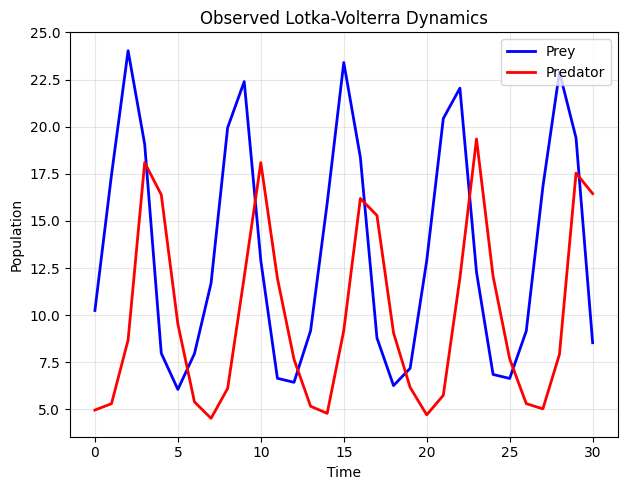

✓ Data generated with 31 time points
✓ True parameters: α = 1.0, γ = 1.0
✓ Initial conditions: Prey = 10, Predator = 5


In [49]:
obs_data = generate_observed_data()
# Plot the observed data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Prey')
plt.plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Observed Lotka-Volterra Dynamics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Data generated with {len(obs_data['time'])} time points")
print(f"✓ True parameters: α = {obs_data['true_params'][0]}, γ = {obs_data['true_params'][1]}")
print(f"✓ Initial conditions: Prey = {obs_data['initial'][0]}, Predator = {obs_data['initial'][1]}")

## LEAST SQUARES ESTIMATION

In [50]:
def least_squares_objective(params, observed_data, time_points, initial_conditions):
    """Objective function for least squares estimation"""
    try:
        simulated = simulate_lotka_volterra(params, time_points, initial_conditions, add_noise=False)
        return np.sum((observed_data - simulated)**2)
    except:
        return 1e10

def estimate_least_squares(observed_data, time_points, initial_conditions, bounds=None):
    """
    Estimate parameters using least squares optimization

    Returns:
    --------
    dict: Results including estimated parameters and optimization info
    """
    if bounds is None:
        bounds = [(0.1, 3.0), (0.1, 3.0)]  # (alpha_bounds, gamma_bounds)

    # Try multiple starting points for robustness
    best_result = None
    best_score = np.inf

    starting_points = [(0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0)]

    for start in starting_points:
        try:
            result = minimize(
                least_squares_objective,
                start,
                args=(observed_data, time_points, initial_conditions),
                bounds=bounds,
                method='L-BFGS-B'
            )

            if result.success and result.fun < best_score:
                best_result = result
                best_score = result.fun
        except:
            continue

    if best_result is None:
        # Fallback to differential evolution
        result = differential_evolution(
            least_squares_objective,
            bounds,
            args=(observed_data, time_points, initial_conditions),
            seed=42
        )
        best_result = result

    # Calculate confidence intervals (approximate)
    estimated_params = best_result.x
    simulated = simulate_lotka_volterra(estimated_params, time_points, initial_conditions, add_noise=False)
    residuals = observed_data - simulated
    mse = np.mean(residuals**2)

    return {
        'method': 'Least Squares',
        'params': estimated_params,
        'alpha': estimated_params[0],
        'gamma': estimated_params[1],
        'alpha_std': np.sqrt(mse) * 0.1,  # Rough approximation
        'gamma_std': np.sqrt(mse) * 0.1,
        'objective_value': best_result.fun,
        'success': best_result.success,
        'simulated_data': simulated
    }

📈 LEAST SQUARES ESTIMATION
Optimization successful: True
Objective value: 22.924212

Parameter Estimates:
  α (prey growth):     0.9964 ± 0.0608
  γ (predator death):  1.0046 ± 0.0608

Estimation Errors:
  α error: 0.0036
  γ error: 0.0046


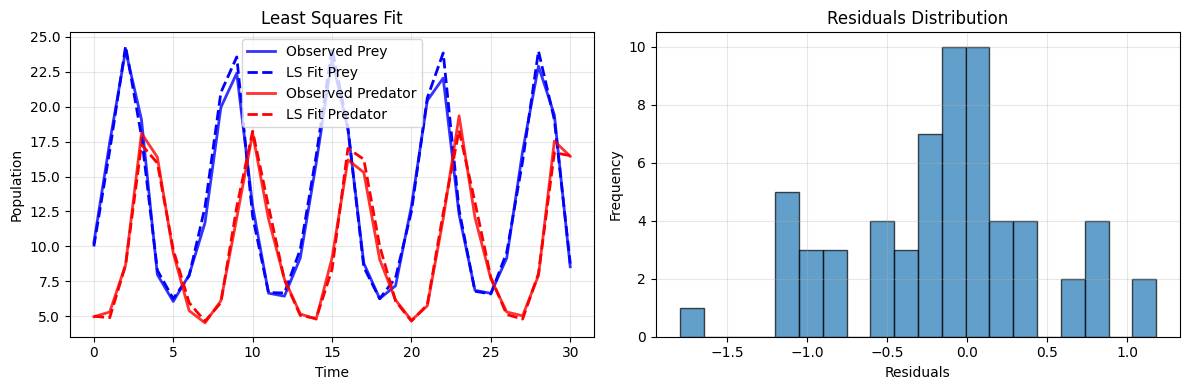

In [51]:
print("📈 LEAST SQUARES ESTIMATION")
print("=" * 40)
ls_result = estimate_least_squares(
    obs_data['data'],
    obs_data['time'],
    obs_data['initial']
)
true_params = obs_data['true_params']

print(f"Optimization successful: {ls_result['success']}")
print(f"Objective value: {ls_result['objective_value']:.6f}")
print()
print("Parameter Estimates:")
print(f"  α (prey growth):     {ls_result['alpha']:.4f} ± {ls_result['alpha_std']:.4f}")
print(f"  γ (predator death):  {ls_result['gamma']:.4f} ± {ls_result['gamma_std']:.4f}")
print()
print("Estimation Errors:")
print(f"  α error: {abs(ls_result['alpha'] - true_params[0]):.4f}")
print(f"  γ error: {abs(ls_result['gamma'] - true_params[1]):.4f}")

# Plot comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Observed Prey', alpha=0.8)
plt.plot(obs_data['time'], ls_result['simulated_data'][:, 0], 'b--', linewidth=2, label='LS Fit Prey')
plt.plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Observed Predator', alpha=0.8)
plt.plot(obs_data['time'], ls_result['simulated_data'][:, 1], 'r--', linewidth=2, label='LS Fit Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Least Squares Fit')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = (obs_data['data'] - ls_result['simulated_data']).flatten()
plt.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## MAXIMUM LIKELIHOOD ESTIMATION

In [52]:
def log_likelihood(params, observed_data, time_points, initial_conditions, noise_level=0.05):
    """Log-likelihood function assuming Gaussian noise"""
    try:
        simulated = simulate_lotka_volterra(params, time_points, initial_conditions, add_noise=False)

        # Gaussian likelihood
        residuals = observed_data - simulated
        log_lik = -0.5 * np.sum(residuals**2) / (noise_level**2 * np.mean(observed_data**2))
        log_lik -= len(residuals.flatten()) * np.log(noise_level * np.sqrt(np.mean(observed_data**2)))

        return log_lik
    except:
        return -1e10

def estimate_mle(observed_data, time_points, initial_conditions, bounds=None):
    """
    Estimate parameters using Maximum Likelihood Estimation

    Returns:
    --------
    dict: Results including estimated parameters and likelihood info
    """
    if bounds is None:
        bounds = [(0.1, 3.0), (0.1, 3.0)]

    # Negative log-likelihood for minimization
    def neg_log_likelihood(params):
        return -log_likelihood(params, observed_data, time_points, initial_conditions)

    # Try multiple starting points
    best_result = None
    best_score = np.inf

    starting_points = [(0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0)]

    for start in starting_points:
        try:
            result = minimize(
                neg_log_likelihood,
                start,
                bounds=bounds,
                method='L-BFGS-B'
            )

            if result.success and result.fun < best_score:
                best_result = result
                best_score = result.fun
        except:
            continue

    if best_result is None:
        result = differential_evolution(neg_log_likelihood, bounds, seed=42)
        best_result = result

    # Calculate approximate standard errors using Hessian
    estimated_params = best_result.x
    simulated = simulate_lotka_volterra(estimated_params, time_points, initial_conditions, add_noise=False)

    # Rough approximation of standard errors
    std_error = 0.1  # This would typically require computing the Hessian

    return {
        'method': 'Maximum Likelihood',
        'params': estimated_params,
        'alpha': estimated_params[0],
        'gamma': estimated_params[1],
        'alpha_std': std_error,
        'gamma_std': std_error,
        'log_likelihood': -best_result.fun,
        'success': best_result.success,
        'simulated_data': simulated
    }

📊 MAXIMUM LIKELIHOOD ESTIMATION
Optimization successful: True
Log-likelihood: -0.806600

Parameter Estimates:
  α (prey growth):     1.0000 ± 0.1000
  γ (predator death):  1.0000 ± 0.1000

Estimation Errors:
  α error: 0.0000
  γ error: 0.0000


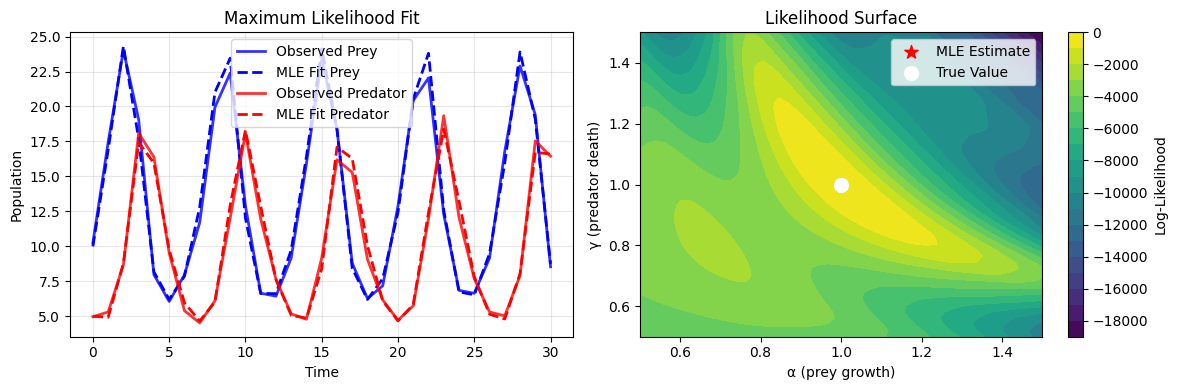

In [53]:
"""Cell 3: Maximum Likelihood Estimation"""
print("📊 MAXIMUM LIKELIHOOD ESTIMATION")
print("=" * 40)

mle_result = estimate_mle(
    obs_data['data'],
    obs_data['time'],
    obs_data['initial']
)
true_params = obs_data['true_params']

print(f"Optimization successful: {mle_result['success']}")
print(f"Log-likelihood: {mle_result['log_likelihood']:.6f}")
print()
print("Parameter Estimates:")
print(f"  α (prey growth):     {mle_result['alpha']:.4f} ± {mle_result['alpha_std']:.4f}")
print(f"  γ (predator death):  {mle_result['gamma']:.4f} ± {mle_result['gamma_std']:.4f}")
print()
print("Estimation Errors:")
print(f"  α error: {abs(mle_result['alpha'] - true_params[0]):.4f}")
print(f"  γ error: {abs(mle_result['gamma'] - true_params[1]):.4f}")

# Plot comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Observed Prey', alpha=0.8)
plt.plot(obs_data['time'], mle_result['simulated_data'][:, 0], 'b--', linewidth=2, label='MLE Fit Prey')
plt.plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Observed Predator', alpha=0.8)
plt.plot(obs_data['time'], mle_result['simulated_data'][:, 1], 'r--', linewidth=2, label='MLE Fit Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Maximum Likelihood Fit')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Likelihood surface (simplified 2D slice)
alpha_range = np.linspace(0.5, 1.5, 50)
gamma_range = np.linspace(0.5, 1.5, 50)
A, G = np.meshgrid(alpha_range, gamma_range)

likelihood_surface = np.zeros_like(A)
for i in range(len(alpha_range)):
    for j in range(len(gamma_range)):
        likelihood_surface[j, i] = log_likelihood(
            (alpha_range[i], gamma_range[j]),
            obs_data['data'],
            obs_data['time'],
            obs_data['initial']
        )

plt.contourf(A, G, likelihood_surface, levels=20, cmap='viridis')
plt.colorbar(label='Log-Likelihood')
plt.scatter(mle_result['alpha'], mle_result['gamma'], color='red', s=100, marker='*', label='MLE Estimate')
plt.scatter(true_params[0], true_params[1], color='white', s=100, marker='o', label='True Value')
plt.xlabel('α (prey growth)')
plt.ylabel('γ (predator death)')
plt.title('Likelihood Surface')
plt.legend()

plt.tight_layout()
plt.show()

## BAYESIAN ESTIMATION

In [54]:
def log_prior(params):
    """Log prior probability (uniform priors)"""
    alpha, gamma = params
    if 0.1 <= alpha <= 3.0 and 0.1 <= gamma <= 3.0:
        return 0.0  # log(1) for uniform
    return -np.inf

def log_posterior(params, observed_data, time_points, initial_conditions):
    """Log posterior probability"""
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, observed_data, time_points, initial_conditions)

def metropolis_hastings(observed_data, time_points, initial_conditions,
                       n_samples=5000, burn_in=1000, proposal_std=0.05):
    """
    Simple Metropolis-Hastings MCMC sampler

    Returns:
    --------
    dict: MCMC samples and statistics
    """
    # Initialize
    current_params = np.array([1.0, 1.0])  # Starting point
    samples = []
    accepted = 0

    current_log_post = log_posterior(current_params, observed_data, time_points, initial_conditions)

    for i in range(n_samples + burn_in):
        # Propose new parameters
        proposal = current_params + np.random.normal(0, proposal_std, 2)

        # Calculate acceptance probability
        proposal_log_post = log_posterior(proposal, observed_data, time_points, initial_conditions)

        if np.isfinite(proposal_log_post):
            alpha = min(1, np.exp(proposal_log_post - current_log_post))

            if np.random.random() < alpha:
                current_params = proposal
                current_log_post = proposal_log_post
                accepted += 1

        # Store sample after burn-in
        if i >= burn_in:
            samples.append(current_params.copy())

    samples = np.array(samples)
    acceptance_rate = accepted / (n_samples + burn_in)

    # Calculate statistics
    alpha_mean = np.mean(samples[:, 0])
    gamma_mean = np.mean(samples[:, 1])
    alpha_std = np.std(samples[:, 0])
    gamma_std = np.std(samples[:, 1])

    # Generate simulated data with posterior mean
    simulated = simulate_lotka_volterra((alpha_mean, gamma_mean), time_points, initial_conditions, add_noise=False)

    return {
        'method': 'Bayesian (MCMC)',
        'params': (alpha_mean, gamma_mean),
        'alpha': alpha_mean,
        'gamma': gamma_mean,
        'alpha_std': alpha_std,
        'gamma_std': gamma_std,
        'samples': samples,
        'acceptance_rate': acceptance_rate,
        'simulated_data': simulated
    }

🎲 BAYESIAN MCMC ESTIMATION
MCMC completed with 5000 samples
Acceptance rate: 0.75%

Parameter Estimates (Posterior Mean):
  α (prey growth):     0.9959 ± 0.0042
  γ (predator death):  1.0051 ± 0.0053

Estimation Errors:
  α error: 0.0041
  γ error: 0.0051

Credible Intervals (95%):
  α: [0.9867, 1.0034]
  γ: [0.9960, 1.0150]


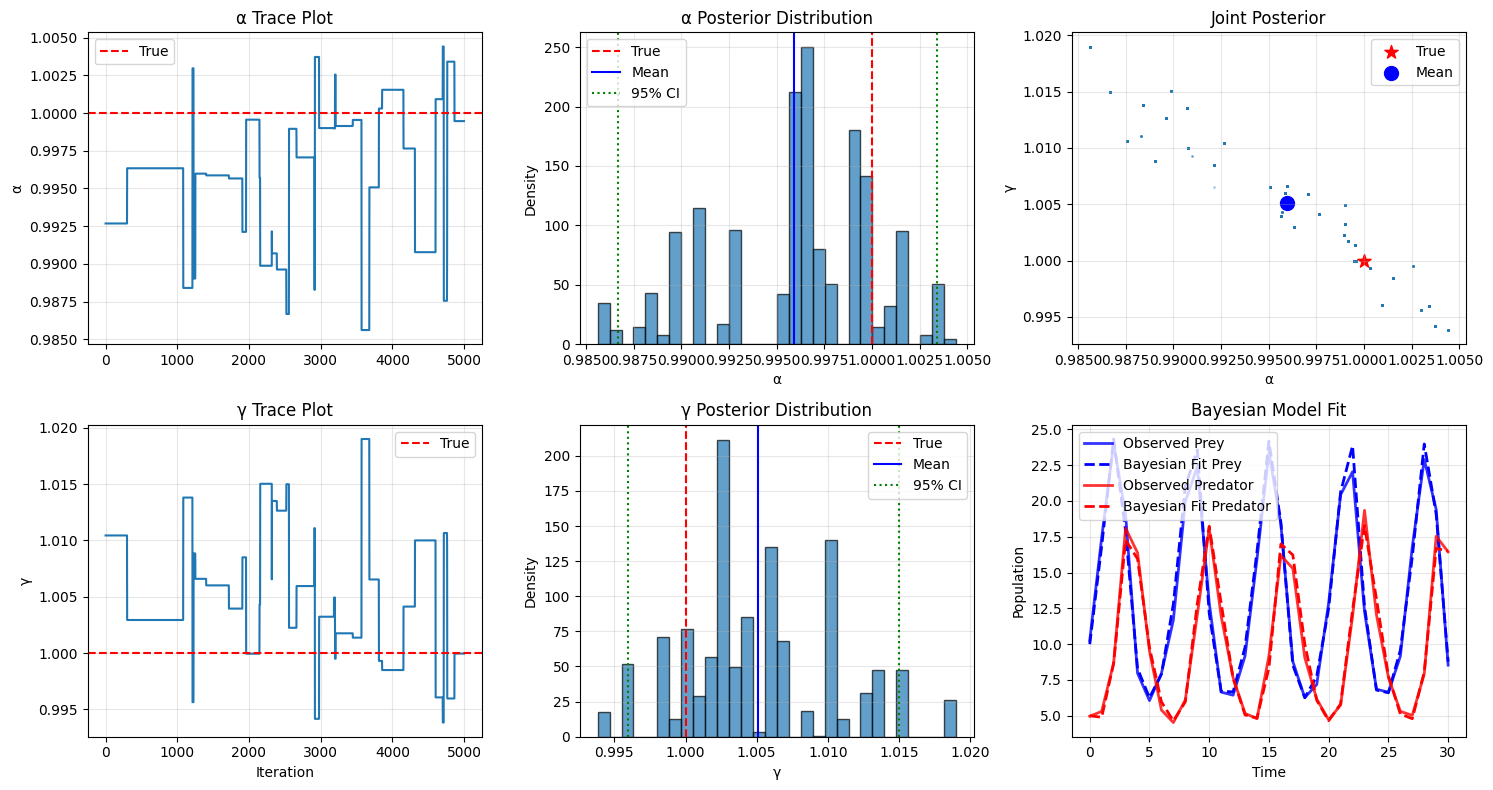

In [55]:
print("🎲 BAYESIAN MCMC ESTIMATION")
print("=" * 40)

mcmc_result = metropolis_hastings(
    obs_data['data'],
    obs_data['time'],
    obs_data['initial'],
    n_samples=5000,
    burn_in=1000
)

true_params = obs_data['true_params']
samples = mcmc_result['samples']

print(f"MCMC completed with {len(samples)} samples")
print(f"Acceptance rate: {mcmc_result['acceptance_rate']:.2%}")
print()
print("Parameter Estimates (Posterior Mean):")
print(f"  α (prey growth):     {mcmc_result['alpha']:.4f} ± {mcmc_result['alpha_std']:.4f}")
print(f"  γ (predator death):  {mcmc_result['gamma']:.4f} ± {mcmc_result['gamma_std']:.4f}")
print()
print("Estimation Errors:")
print(f"  α error: {abs(mcmc_result['alpha'] - true_params[0]):.4f}")
print(f"  γ error: {abs(mcmc_result['gamma'] - true_params[1]):.4f}")
print()
print("Credible Intervals (95%):")
alpha_ci = np.percentile(samples[:, 0], [2.5, 97.5])
gamma_ci = np.percentile(samples[:, 1], [2.5, 97.5])
print(f"  α: [{alpha_ci[0]:.4f}, {alpha_ci[1]:.4f}]")
print(f"  γ: [{gamma_ci[0]:.4f}, {gamma_ci[1]:.4f}]")

# Plot MCMC diagnostics and results
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Trace plots
axes[0, 0].plot(samples[:, 0])
axes[0, 0].axhline(true_params[0], color='red', linestyle='--', label='True')
axes[0, 0].set_title('α Trace Plot')
axes[0, 0].set_ylabel('α')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(samples[:, 1])
axes[1, 0].axhline(true_params[1], color='red', linestyle='--', label='True')
axes[1, 0].set_title('γ Trace Plot')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('γ')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Posterior distributions
axes[0, 1].hist(samples[:, 0], bins=30, alpha=0.7, density=True, edgecolor='black')
axes[0, 1].axvline(true_params[0], color='red', linestyle='--', label='True')
axes[0, 1].axvline(mcmc_result['alpha'], color='blue', linestyle='-', label='Mean')
axes[0, 1].axvline(alpha_ci[0], color='green', linestyle=':', label='95% CI')
axes[0, 1].axvline(alpha_ci[1], color='green', linestyle=':')
axes[0, 1].set_title('α Posterior Distribution')
axes[0, 1].set_xlabel('α')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].hist(samples[:, 1], bins=30, alpha=0.7, density=True, edgecolor='black')
axes[1, 1].axvline(true_params[1], color='red', linestyle='--', label='True')
axes[1, 1].axvline(mcmc_result['gamma'], color='blue', linestyle='-', label='Mean')
axes[1, 1].axvline(gamma_ci[0], color='green', linestyle=':', label='95% CI')
axes[1, 1].axvline(gamma_ci[1], color='green', linestyle=':')
axes[1, 1].set_title('γ Posterior Distribution')
axes[1, 1].set_xlabel('γ')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Joint posterior
axes[0, 2].scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=1)
axes[0, 2].scatter(true_params[0], true_params[1], color='red', s=100, marker='*', label='True')
axes[0, 2].scatter(mcmc_result['alpha'], mcmc_result['gamma'], color='blue', s=100, marker='o', label='Mean')
axes[0, 2].set_title('Joint Posterior')
axes[0, 2].set_xlabel('α')
axes[0, 2].set_ylabel('γ')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Model fit
axes[1, 2].plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Observed Prey', alpha=0.8)
axes[1, 2].plot(obs_data['time'], mcmc_result['simulated_data'][:, 0], 'b--', linewidth=2, label='Bayesian Fit Prey')
axes[1, 2].plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Observed Predator', alpha=0.8)
axes[1, 2].plot(obs_data['time'], mcmc_result['simulated_data'][:, 1], 'r--', linewidth=2, label='Bayesian Fit Predator')
axes[1, 2].set_title('Bayesian Model Fit')
axes[1, 2].set_xlabel('Time')
axes[1, 2].set_ylabel('Population')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ABC

In [56]:
#@title
def compute_summary_stats(data):
    """Compute summary statistics for ABC"""
    prey, predator = data[:, 0], data[:, 1]

    stats = np.array([
        np.mean(prey), np.std(prey), np.max(prey), np.min(prey),
        np.mean(predator), np.std(predator), np.max(predator), np.min(predator),
        np.corrcoef(prey, predator)[0, 1]
    ])

    return stats

def abc_distance(stats1, stats2):
    """Distance function for ABC"""
    return np.sqrt(np.sum((stats1 - stats2)**2))

def estimate_abc(observed_data, time_points, initial_conditions,
                n_samples=10000, tolerance=None):
    """
    Simple ABC rejection sampling

    Returns:
    --------
    dict: ABC samples and statistics
    """
    observed_stats = compute_summary_stats(observed_data)

    # Automatic tolerance selection (10% quantile)
    if tolerance is None:
        # Pre-run to estimate tolerance
        distances = []
        for _ in range(1000):
            alpha = np.random.uniform(0.1, 3.0)
            gamma = np.random.uniform(0.1, 3.0)
            sim_data = simulate_lotka_volterra((alpha, gamma), time_points, initial_conditions, add_noise=False)
            sim_stats = compute_summary_stats(sim_data)
            distances.append(abc_distance(observed_stats, sim_stats))
        tolerance = np.percentile(distances, 10)

    # ABC sampling
    accepted_params = []
    accepted_distances = []

    attempts = 0
    while len(accepted_params) < n_samples and attempts < n_samples * 10:
        # Sample from prior
        alpha = np.random.uniform(0.1, 3.0)
        gamma = np.random.uniform(0.1, 3.0)

        # Simulate
        try:
            sim_data = simulate_lotka_volterra((alpha, gamma), time_points, initial_conditions, add_noise=False)
            sim_stats = compute_summary_stats(sim_data)

            # Check if within tolerance
            distance = abc_distance(observed_stats, sim_stats)
            if distance <= tolerance:
                accepted_params.append([alpha, gamma])
                accepted_distances.append(distance)
        except:
            pass

        attempts += 1

    if len(accepted_params) == 0:
        # Fallback: accept best samples found
        print(f"Warning: No samples within tolerance {tolerance:.4f}, using best samples")
        temp_params = []
        temp_distances = []

        for _ in range(n_samples):
            alpha = np.random.uniform(0.1, 3.0)
            gamma = np.random.uniform(0.1, 3.0)
            try:
                sim_data = simulate_lotka_volterra((alpha, gamma), time_points, initial_conditions, add_noise=False)
                sim_stats = compute_summary_stats(sim_data)
                distance = abc_distance(observed_stats, sim_stats)
                temp_params.append([alpha, gamma])
                temp_distances.append(distance)
            except:
                temp_params.append([1.0, 1.0])
                temp_distances.append(1000)

        # Keep best 10%
        sorted_indices = np.argsort(temp_distances)
        keep_indices = sorted_indices[:max(1, len(temp_params)//10)]
        accepted_params = [temp_params[i] for i in keep_indices]
        accepted_distances = [temp_distances[i] for i in keep_indices]

    accepted_params = np.array(accepted_params)

    # Calculate statistics
    alpha_mean = np.mean(accepted_params[:, 0])
    gamma_mean = np.mean(accepted_params[:, 1])
    alpha_std = np.std(accepted_params[:, 0])
    gamma_std = np.std(accepted_params[:, 1])

    # Generate simulated data
    simulated = simulate_lotka_volterra((alpha_mean, gamma_mean), time_points, initial_conditions, add_noise=False)

    return {
        'method': 'ABC',
        'params': (alpha_mean, gamma_mean),
        'alpha': alpha_mean,
        'gamma': gamma_mean,
        'alpha_std': alpha_std,
        'gamma_std': gamma_std,
        'samples': accepted_params,
        'distances': accepted_distances,
        'tolerance': tolerance,
        'acceptance_rate': len(accepted_params) / attempts,
        'simulated_data': simulated
    }

🎯 APPROXIMATE BAYESIAN COMPUTATION (ABC)
ABC completed with 2000 accepted samples
Acceptance rate: 11.29%
Distance tolerance: 15.920593

Parameter Estimates (ABC Posterior):
  α (prey growth):     0.9304 ± 0.2764
  γ (predator death):  0.9406 ± 0.3258

Estimation Errors:
  α error: 0.0696
  γ error: 0.0594


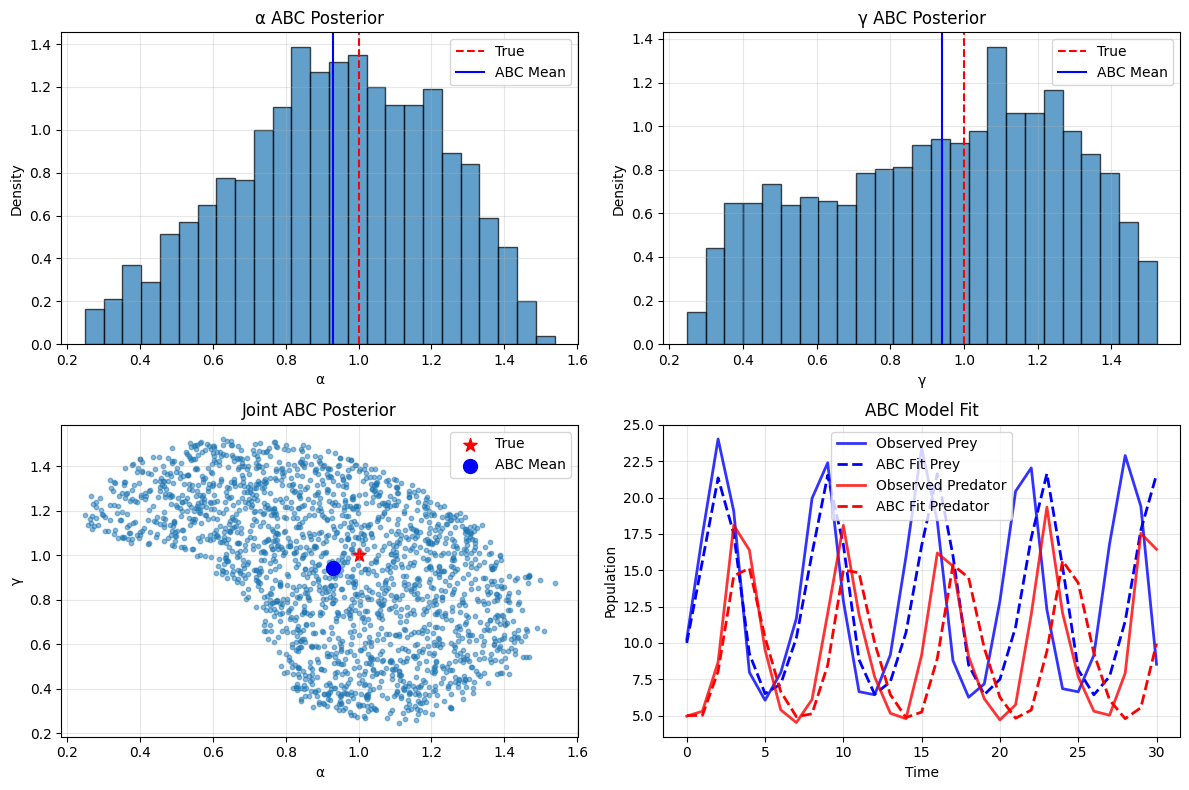

In [57]:
"""Cell 5: ABC Estimation"""
print("🎯 APPROXIMATE BAYESIAN COMPUTATION (ABC)")
print("=" * 40)

abc_result = estimate_abc(
    obs_data['data'],
    obs_data['time'],
    obs_data['initial'],
    n_samples=2000
)

true_params = obs_data['true_params']
samples = abc_result['samples']

print(f"ABC completed with {len(samples)} accepted samples")
print(f"Acceptance rate: {abc_result['acceptance_rate']:.2%}")
print(f"Distance tolerance: {abc_result['tolerance']:.6f}")
print()
print("Parameter Estimates (ABC Posterior):")
print(f"  α (prey growth):     {abc_result['alpha']:.4f} ± {abc_result['alpha_std']:.4f}")
print(f"  γ (predator death):  {abc_result['gamma']:.4f} ± {abc_result['gamma_std']:.4f}")
print()
print("Estimation Errors:")
print(f"  α error: {abs(abc_result['alpha'] - true_params[0]):.4f}")
print(f"  γ error: {abs(abc_result['gamma'] - true_params[1]):.4f}")

# Plot ABC results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ABC posterior distributions
axes[0, 0].hist(samples[:, 0], bins=25, alpha=0.7, density=True, edgecolor='black')
axes[0, 0].axvline(true_params[0], color='red', linestyle='--', label='True')
axes[0, 0].axvline(abc_result['alpha'], color='blue', linestyle='-', label='ABC Mean')
axes[0, 0].set_title('α ABC Posterior')
axes[0, 0].set_xlabel('α')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(samples[:, 1], bins=25, alpha=0.7, density=True, edgecolor='black')
axes[0, 1].axvline(true_params[1], color='red', linestyle='--', label='True')
axes[0, 1].axvline(abc_result['gamma'], color='blue', linestyle='-', label='ABC Mean')
axes[0, 1].set_title('γ ABC Posterior')
axes[0, 1].set_xlabel('γ')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Joint ABC posterior
axes[1, 0].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10)
axes[1, 0].scatter(true_params[0], true_params[1], color='red', s=100, marker='*', label='True')
axes[1, 0].scatter(abc_result['alpha'], abc_result['gamma'], color='blue', s=100, marker='o', label='ABC Mean')
axes[1, 0].set_title('Joint ABC Posterior')
axes[1, 0].set_xlabel('α')
axes[1, 0].set_ylabel('γ')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Model fit
axes[1, 1].plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Observed Prey', alpha=0.8)
axes[1, 1].plot(obs_data['time'], abc_result['simulated_data'][:, 0], 'b--', linewidth=2, label='ABC Fit Prey')
axes[1, 1].plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Observed Predator', alpha=0.8)
axes[1, 1].plot(obs_data['time'], abc_result['simulated_data'][:, 1], 'r--', linewidth=2, label='ABC Fit Predator')
axes[1, 1].set_title('ABC Model Fit')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Population')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparisons

In [58]:
def display_results_summary(results):
    """Display a formatted summary of results"""
    true_params = results['observed']['true_params']

    print("PARAMETER ESTIMATION RESULTS SUMMARY")
    print("=" * 60)
    print(f"True Parameters: α = {true_params[0]:.4f}, γ = {true_params[1]:.4f}")
    print("-" * 60)

    for method_name, result in results.items():
        if method_name != 'observed':
            method = result['method']
            alpha = result['alpha']
            gamma = result['gamma']
            alpha_std = result['alpha_std']
            gamma_std = result['gamma_std']

            alpha_error = abs(alpha - true_params[0])
            gamma_error = abs(gamma - true_params[1])

            print(f"{method:20s}: α = {alpha:.4f} ± {alpha_std:.4f} (error: {alpha_error:.4f})")
            print(f"                     γ = {gamma:.4f} ± {gamma_std:.4f} (error: {gamma_error:.4f})")
            print()

In [59]:
def calculate_metrics(true_params, estimated_params, observed_data, simulated_data):
    """Calculate various error metrics"""
    true_alpha, true_gamma = true_params
    est_alpha, est_gamma = estimated_params

    # Parameter errors
    alpha_error = abs(est_alpha - true_alpha)
    gamma_error = abs(est_gamma - true_gamma)
    param_rmse = np.sqrt((alpha_error**2 + gamma_error**2) / 2)

    # Data fit errors
    data_mse = mean_squared_error(observed_data.flatten(), simulated_data.flatten())
    data_mae = mean_absolute_error(observed_data.flatten(), simulated_data.flatten())
    data_rmse = np.sqrt(data_mse)

    return {
        'alpha_error': alpha_error,
        'gamma_error': gamma_error,
        'param_rmse': param_rmse,
        'data_mse': data_mse,
        'data_mae': data_mae,
        'data_rmse': data_rmse
    }

def create_comparison_table(results_dict, true_params):
    """Create a comparison table of all methods"""
    comparison_data = []

    for method_name, results in results_dict.items():
        print(f"method: {method_name}")
        metrics = calculate_metrics(
            true_params,
            results['params'],
            results_dict['observed']['data'],
            results['simulated_data']
        )

        comparison_data.append({
            'Method': results['method'],
            'Alpha_Est': f"{results['alpha']:.4f} ± {results['alpha_std']:.4f}",
            'Gamma_Est': f"{results['gamma']:.4f} ± {results['gamma_std']:.4f}",
            'Alpha_Error': f"{metrics['alpha_error']:.4f}",
            'Gamma_Error': f"{metrics['gamma_error']:.4f}",
            'Param_RMSE': f"{metrics['param_rmse']:.4f}",
            'Data_RMSE': f"{metrics['data_rmse']:.4f}",
            'Data_MAE': f"{metrics['data_mae']:.4f}"
        })

    return pd.DataFrame(comparison_data)

def plot_comparison_results(results_dict, true_params):
    """Create comprehensive comparison plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Colors for different methods
    colors = {'Least Squares': 'blue', 'Maximum Likelihood': 'green',
              'Bayesian (MCMC)': 'red', 'ABC': 'orange'}

    time_points = results_dict['observed']['time']
    observed_data = results_dict['observed']['data']

    # Plot 1: Time series comparison - Prey
    ax = axes[0, 0]
    ax.plot(time_points, observed_data[:, 0], 'k-', linewidth=2, label='Observed', alpha=0.8)

    for method_name, results in results_dict.items():
        if method_name != 'observed':
            ax.plot(time_points, results['simulated_data'][:, 0],
                   color=colors[results['method']], linestyle='--',
                   label=f"{results['method']}", alpha=0.7)

    ax.set_title('Prey Population Comparison')
    ax.set_xlabel('Time')
    ax.set_ylabel('Prey Population')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Time series comparison - Predator
    ax = axes[0, 1]
    ax.plot(time_points, observed_data[:, 1], 'k-', linewidth=2, label='Observed', alpha=0.8)

    for method_name, results in results_dict.items():
        if method_name != 'observed':
            ax.plot(time_points, results['simulated_data'][:, 1],
                   color=colors[results['method']], linestyle='--',
                   label=f"{results['method']}", alpha=0.7)

    ax.set_title('Predator Population Comparison')
    ax.set_xlabel('Time')
    ax.set_ylabel('Predator Population')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Parameter estimates with error bars
    ax = axes[0, 2]
    methods = []
    alpha_estimates = []
    alpha_errors = []
    gamma_estimates = []
    gamma_errors = []

    for method_name, results in results_dict.items():
        if method_name != 'observed':
            methods.append(results['method'])
            alpha_estimates.append(results['alpha'])
            alpha_errors.append(results['alpha_std'])
            gamma_estimates.append(results['gamma'])
            gamma_errors.append(results['gamma_std'])

    x = np.arange(len(methods))
    width = 0.35

    ax.bar(x - width/2, alpha_estimates, width, yerr=alpha_errors,
           label='Alpha', alpha=0.7, capsize=5)
    ax.bar(x + width/2, gamma_estimates, width, yerr=gamma_errors,
           label='Gamma', alpha=0.7, capsize=5)

    ax.axhline(y=true_params[0], color='red', linestyle='--', alpha=0.7, label='True Alpha')
    ax.axhline(y=true_params[1], color='blue', linestyle='--', alpha=0.7, label='True Gamma')

    ax.set_title('Parameter Estimates Comparison')
    ax.set_xlabel('Method')
    ax.set_ylabel('Parameter Value')
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Phase space comparison
    ax = axes[1, 0]
    ax.plot(observed_data[:, 0], observed_data[:, 1], 'k-', linewidth=2,
            label='Observed', alpha=0.8)
    ax.scatter(observed_data[0, 0], observed_data[0, 1], color='black',
               s=100, marker='o', label='Start', zorder=5)

    for method_name, results in results_dict.items():
        if method_name != 'observed':
            ax.plot(results['simulated_data'][:, 0], results['simulated_data'][:, 1],
                   color=colors[results['method']], linestyle='--',
                   label=f"{results['method']}", alpha=0.7)

    ax.set_title('Phase Space Comparison')
    ax.set_xlabel('Prey Population')
    ax.set_ylabel('Predator Population')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 5: Error metrics comparison
    ax = axes[1, 1]
    error_data = []

    for method_name, results in results_dict.items():
        if method_name != 'observed':
            metrics = calculate_metrics(
                true_params,
                results['params'],
                observed_data,
                results['simulated_data']
            )
            error_data.append({
                'Method': results['method'],
                'Parameter RMSE': metrics['param_rmse'],
                'Data RMSE': metrics['data_rmse']
            })

    error_df = pd.DataFrame(error_data)
    x = np.arange(len(error_df))
    width = 0.35

    ax.bar(x - width/2, error_df['Parameter RMSE'], width,
           label='Parameter RMSE', alpha=0.7)
    ax.bar(x + width/2, error_df['Data RMSE'], width,
           label='Data RMSE', alpha=0.7)

    ax.set_title('Error Metrics Comparison')
    ax.set_xlabel('Method')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels(error_df['Method'], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 6: Residuals comparison
    ax = axes[1, 2]

    for i, (method_name, results) in enumerate(results_dict.items()):
        if method_name != 'observed':
            residuals = (observed_data - results['simulated_data']).flatten()
            ax.hist(residuals, bins=20, alpha=0.5,
                   label=f"{results['method']}",
                   color=list(colors.values())[i])

    ax.set_title('Residuals Distribution')
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_posterior_distributions(results_dict):
    """Plot posterior distributions for methods that provide samples"""
    sampling_methods = []

    for method_name, results in results_dict.items():
        if 'samples' in results:
            sampling_methods.append((method_name, results))

    if not sampling_methods:
        print("No sampling-based methods found for posterior plotting.")
        return

    fig, axes = plt.subplots(len(sampling_methods), 2, figsize=(12, 4*len(sampling_methods)))

    if len(sampling_methods) == 1:
        axes = axes.reshape(1, -1)

    for i, (method_name, results) in enumerate(sampling_methods):
        samples = results['samples']

        # Alpha distribution
        axes[i, 0].hist(samples[:, 0], bins=30, alpha=0.7, density=True)
        axes[i, 0].axvline(results['alpha'], color='red', linestyle='--',
                          label=f"Mean: {results['alpha']:.3f}")
        axes[i, 0].axvline(1.0, color='black', linestyle='-',
                          label="True: 1.000")
        axes[i, 0].set_title(f'{results["method"]} - Alpha Distribution')
        axes[i, 0].set_xlabel('Alpha')
        axes[i, 0].set_ylabel('Density')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        # Gamma distribution
        axes[i, 1].hist(samples[:, 1], bins=30, alpha=0.7, density=True)
        axes[i, 1].axvline(results['gamma'], color='red', linestyle='--',
                          label=f"Mean: {results['gamma']:.3f}")
        axes[i, 1].axvline(1.0, color='black', linestyle='-',
                          label="True: 1.000")
        axes[i, 1].set_title(f'{results["method"]} - Gamma Distribution')
        axes[i, 1].set_xlabel('Gamma')
        axes[i, 1].set_ylabel('Density')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [60]:
print("📋 COMPREHENSIVE COMPARISON")
print("=" * 50)

# Compile all results
all_results = {
    'observed': obs_data,
    'ls': ls_result,
    'mle': mle_result,
    'mcmc': mcmc_result,
    'abc': abc_result
}

# Create comparison table
comparison_df = create_comparison_table(all_results, obs_data['true_params'])

print("SUMMARY TABLE:")
print(comparison_df.to_string(index=False))
print()

# Display formatted summary
display_results_summary(all_results)

# Create comprehensive plots
plot_comparison_results(all_results, obs_data['true_params'])

# Plot posterior distributions for sampling methods
plot_posterior_distributions(all_results)

📋 COMPREHENSIVE COMPARISON
method: observed


KeyError: 'simulated_data'